# MuTrans script: cisplatin entry

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
import matplotlib.pyplot as plt
import pyMuTrans as pm
import hdf5plugin
import gc
import seaborn as sns

datadir = "data/"

In [2]:
adata = sc.read(datadir+'entry_seurat.h5ad')
adata

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 8223 × 22754
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Sample', 'Barcode', 'sizeFactor', 'CMO', 'CellID', 'ID', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'Counts', 'replicate', 'sum', 'detected', 'subsets_mt_sum', 'subsets_mt_detected', 'subsets_mt_percent', 'subsets_linc_sum', 'subsets_linc_detected', 'subsets_linc_percent', 'subsets_ribo_sum', 'subsets_ribo_detected', 'subsets_ribo_percent', 'total', 'Seurat.Phase', 'Seurat.S', 'Seurat.G2M', 'Cyclone.Phase', 'Cyclone.G1', 'Cyclone.S', 'Cyclone.G2M', 'Tricycle.Phase', 'Tricycle.Position', 'nCount_SCT', 'nFeature_SCT', 'Seurat.Cycle.Score', 'snn_res.0.2', 'seurat_clusters.0.2', 'snn_res.0.4', 'seurat_clusters.0.4', 'snn_res.0.6', 'seurat_clusters.0.6', 'snn_res.0.8', 'seurat_clusters.0.8', 'snn_res.1', 'seurat_clusters.1', 'snn_res.1.2', 'seurat_clusters.1.2', 'snn_res.1.4', 'seurat_clusters.1.4', 'snn_res.1.6', 'seurat_clusters.1.6', 'snn_res.1.8', 'seurat_clusters.1.8', 

In [3]:
adata.layers["raw_counts"] = adata.raw.X
adata.layers["seurat_lognorm"] = adata.X
adata.X = adata.raw.X

In [4]:
adata.obs = adata.obs[['Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score']]
adata.obsm = []
adata

AnnData object with n_obs × n_vars = 8223 × 22754
    obs: 'Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score'
    var: 'features'
    layers: 'raw_counts', 'seurat_lognorm'

In [5]:
# Check adata has raw counts matrix
df = pd.DataFrame.sparse.from_spmatrix(adata.X)
df.head(10)

0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    3.0  ...   
1    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    4.0  ...   
2    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    1.0    0.0    0.0    1.0    1.0    8.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    4.0  ...   
5    3.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    1.0  ...   
6    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    1.0    3.0  ...   
7    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    1.0   13.0  ...   
8    0.0    0.0    0.0    0.0    1.0    1.0    0.0    3.0    3.0    3.0  ...   
9    3.0    0.0    0.0    0.0    2.0    0.0    0.0    1.0    8.0    7.0  ...   

   22744  22745  22746  22747  22748  22749  22750  22751  22752  22753  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    3.0    0.0  
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0  
4    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    1.0    0.0  
5    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0  
6    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
7    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0  
8    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
9    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0  

[10 rows x 22754 columns]

## Pre-processing

Quick QC

In [6]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # Annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars = ['mt'], percent_top = None, log1p = False, inplace = True)

Normalisation

In [7]:
sc.pp.normalize_total(adata, target_sum = 1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, min_mean = 0.0125, max_mean = 3, min_disp = 0.5)

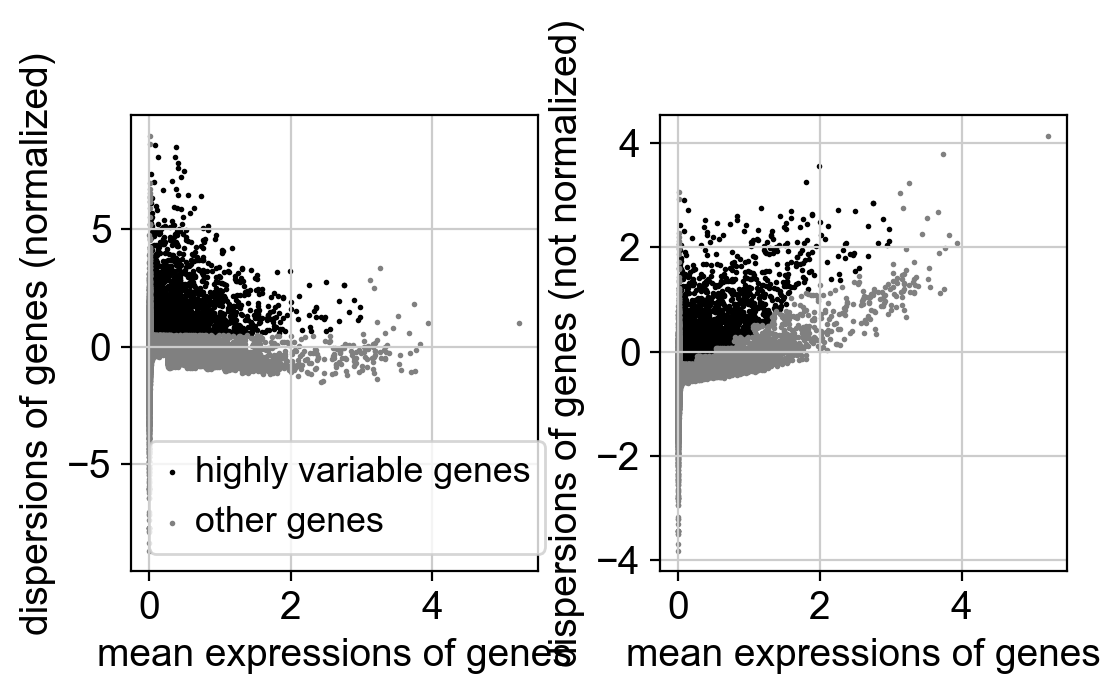

In [8]:
sc.pl.highly_variable_genes(adata)

In [9]:
# Set .raw attribute of AnnData object to the normalised and logarithmized raw gene expression
adata.raw = adata
# Filter for highly variable genes
adata = adata[:, adata.var.highly_variable]

In [10]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\_core\anndata.py:1294: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df

In [11]:
sc.pp.scale(adata, max_value = 10) # Clips values exceeding sd = 10

Reduced dims

In [12]:
sc.tl.pca(adata, svd_solver = 'arpack')

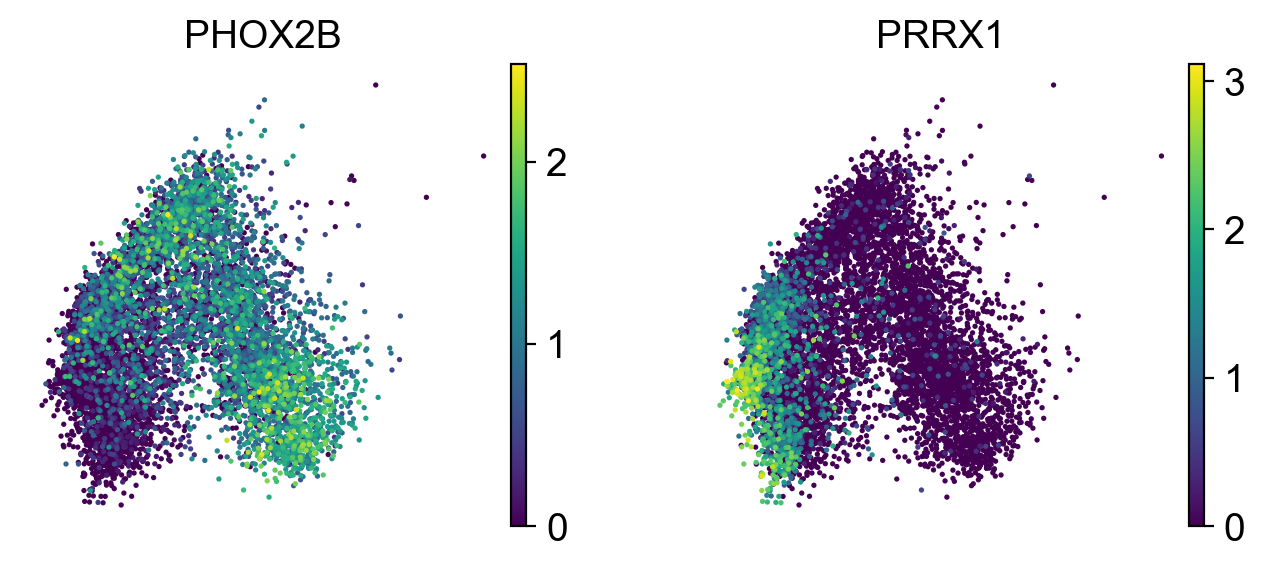

In [13]:
sc.pl.pca(adata, color = ['PHOX2B','PRRX1'])

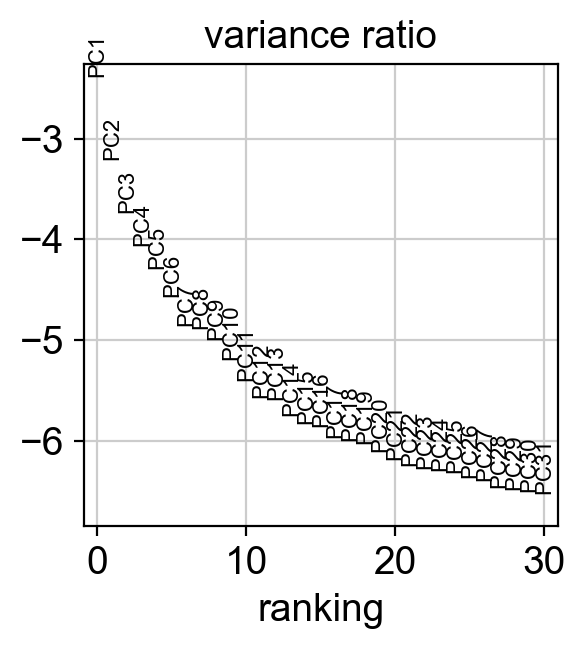

In [14]:
sc.pl.pca_variance_ratio(adata, log = True)

In [15]:
sc.pp.neighbors(adata, n_neighbors = 10, n_pcs = 40)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\umap\distances.py:1086: NumbaD

In [16]:
sc.tl.umap(adata)

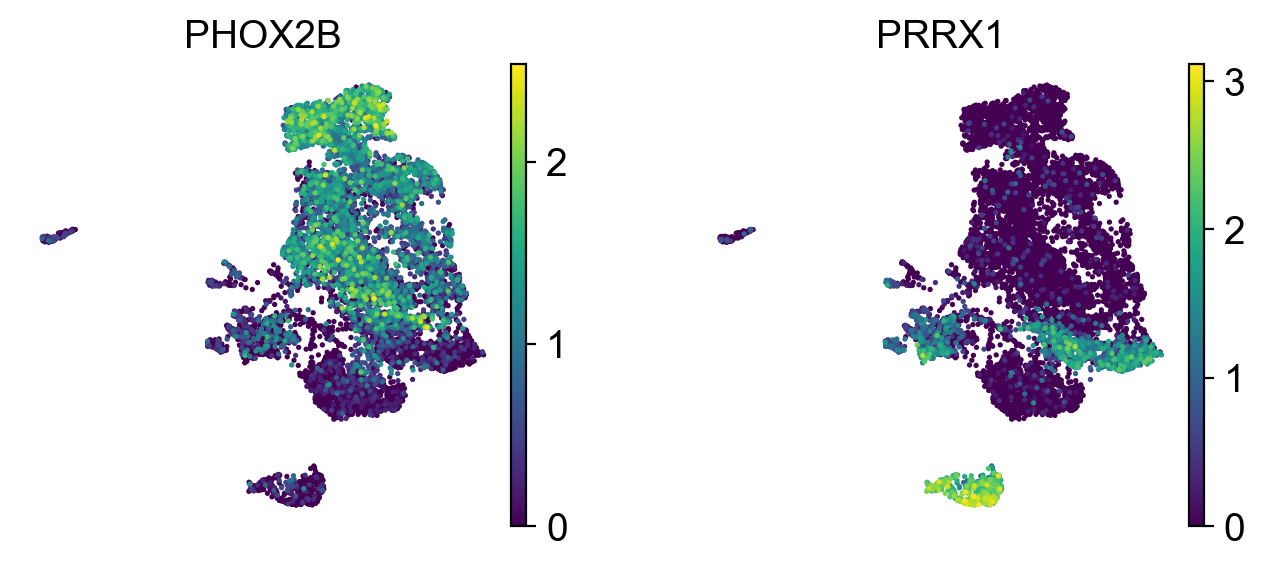

In [17]:
sc.pl.umap(adata, color = ['PHOX2B', 'PRRX1'])

Clustering

In [18]:
sc.tl.leiden(adata, resolution = 0.1)

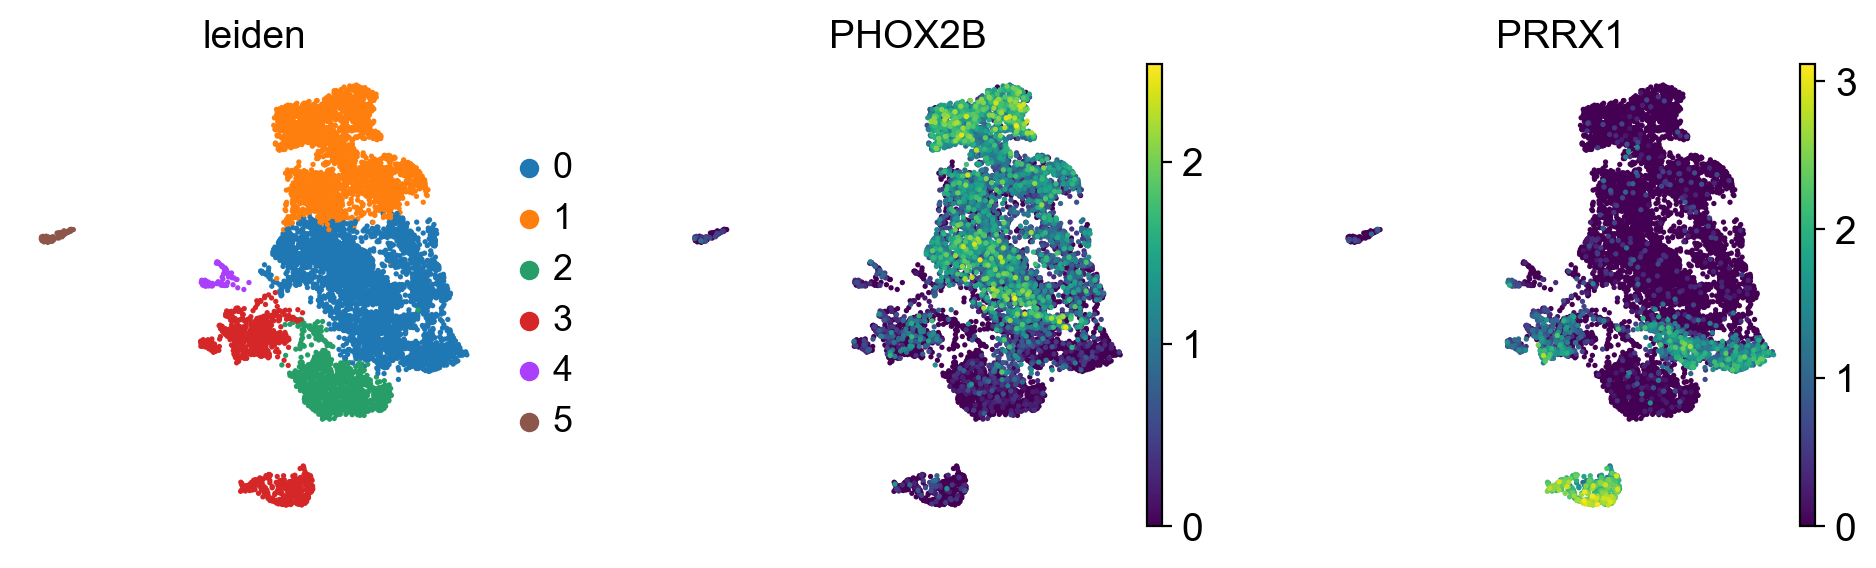

In [19]:
sc.pl.umap(adata, color = ['leiden', 'PHOX2B', 'PRRX1'])

In [20]:
adata.write_h5ad(
    datadir+"entry_scanpy.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

Marker genes

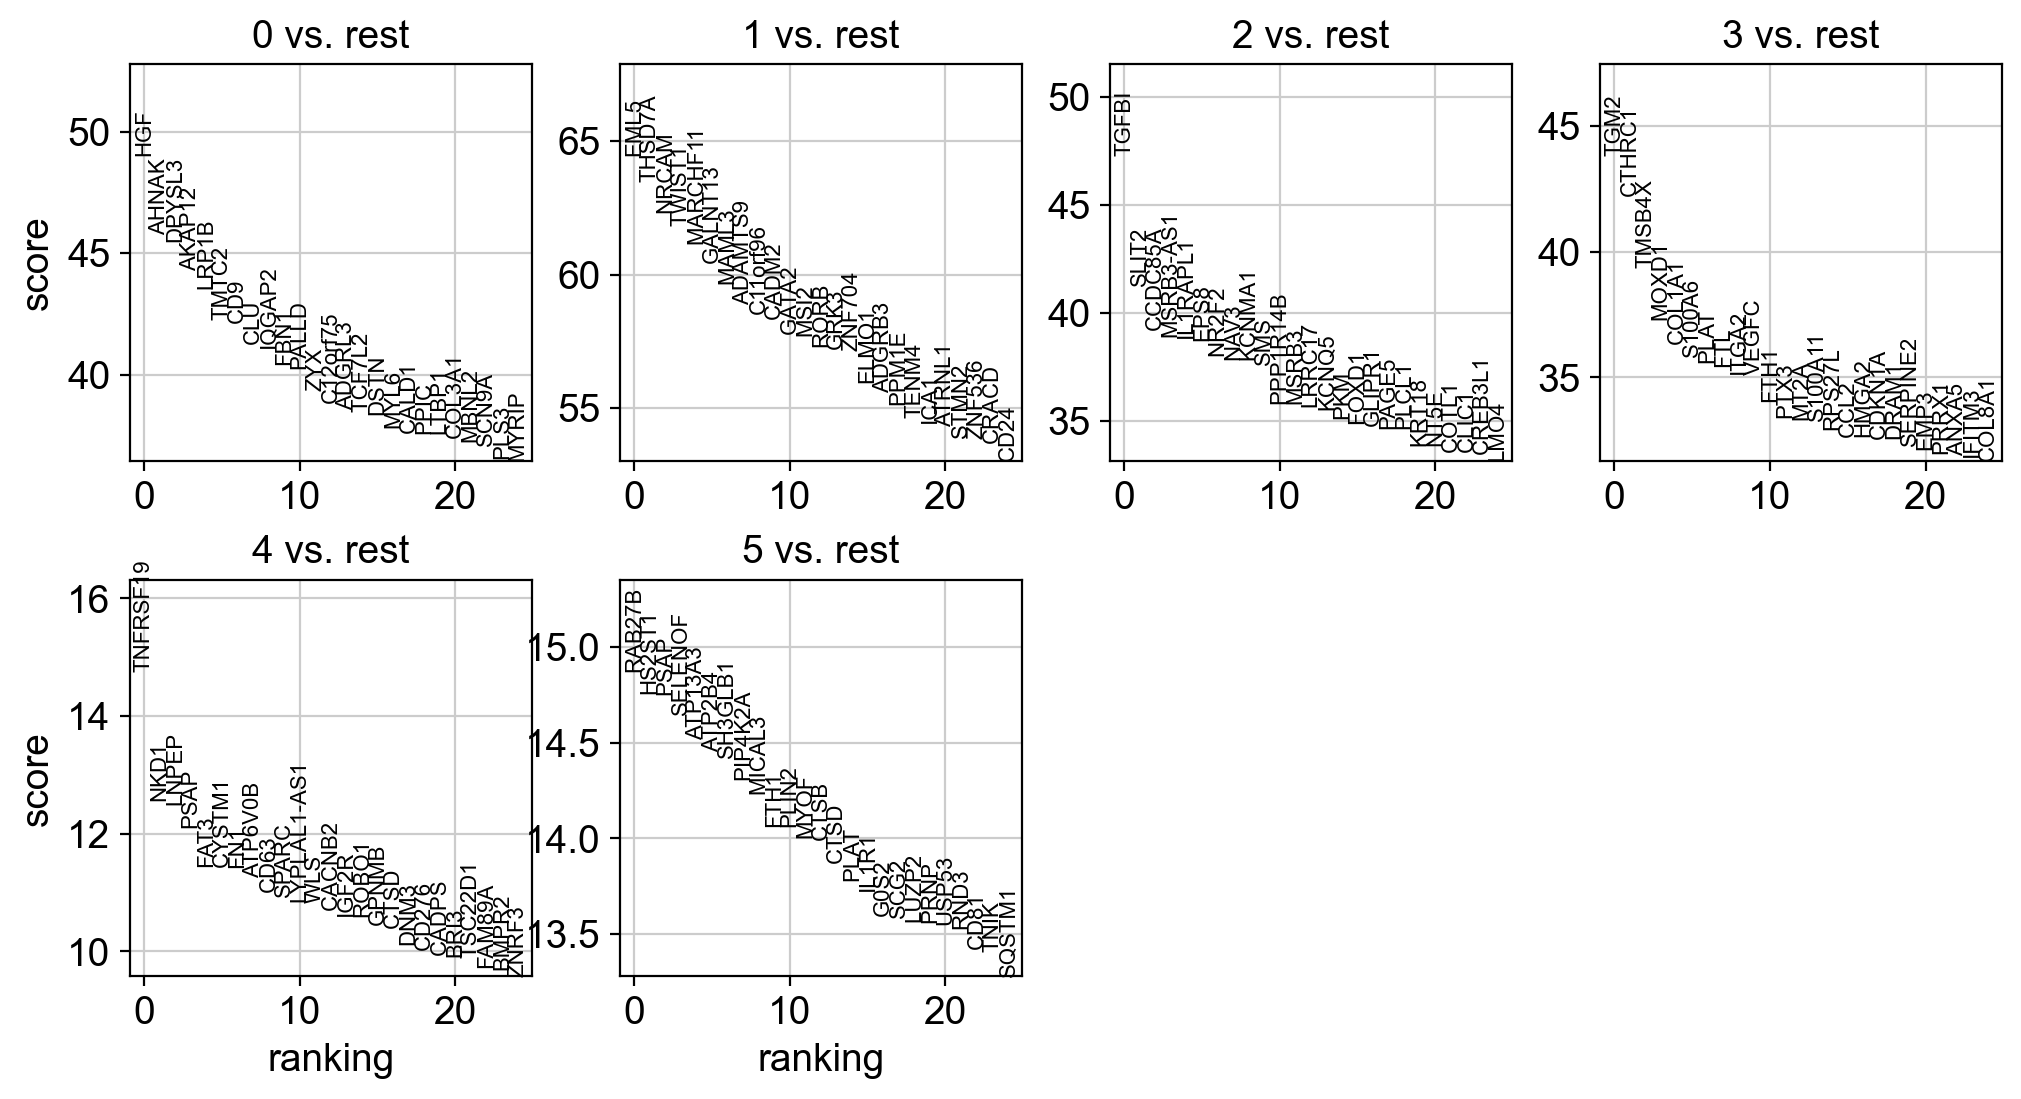

In [21]:
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes = 25, sharey = False)

PAGA analysis

In [22]:
adata = sc.read(datadir+"entry_scanpy.h5ad")

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


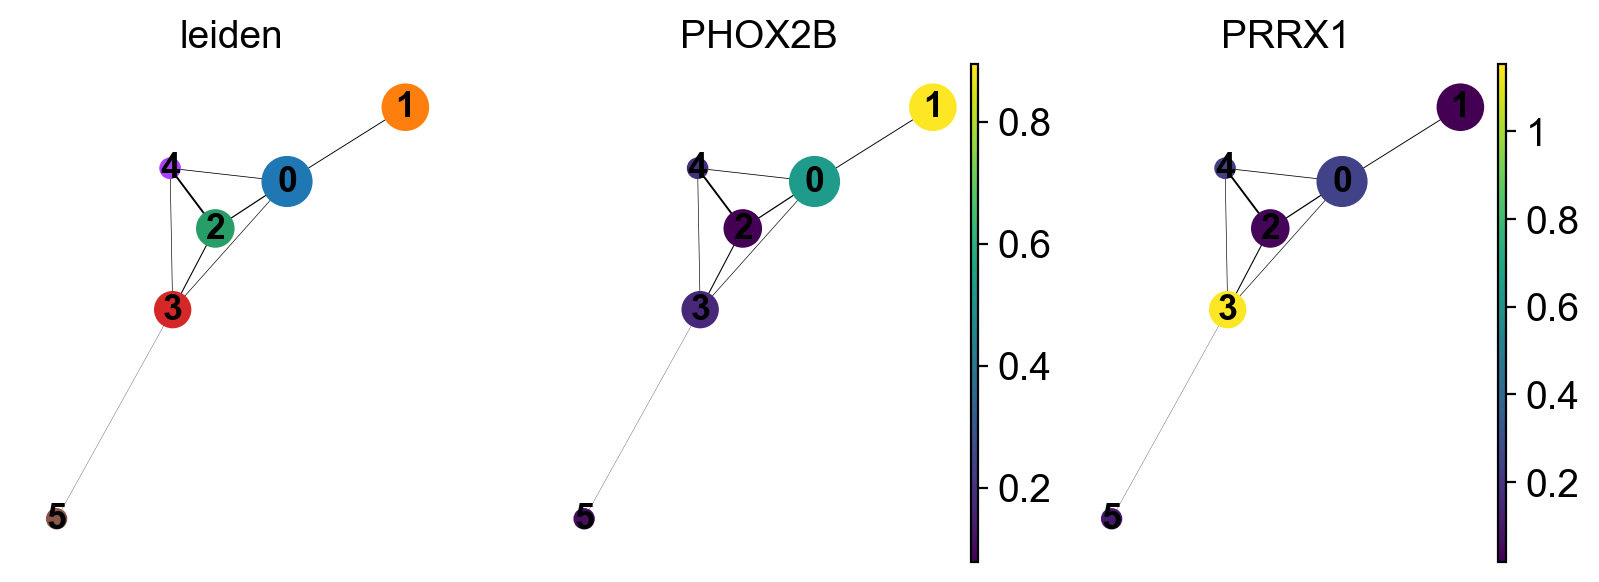

In [23]:
sc.tl.paga(adata, groups = 'leiden')
sc.pl.paga(adata, color = ['leiden', 'PHOX2B', 'PRRX1'])

## Mutrans analysis

In [ ]:
sc.tl.tsne(adata, n_pcs = 30)

In [25]:
sc.pp.neighbors(adata, metric = 'cosine', n_neighbors = 60, use_rep = 'X')

In [26]:
adata.write_h5ad(
    datadir+"entry_scanpy_nn.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

#### Start run from here

In [8]:
plotdir = "../plots/entry/"

In [45]:
adata = sc.read(datadir+"entry_scanpy_nn.h5ad")

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [46]:
gc.collect()

40115

In [47]:
par = {"choice_distance":"cosine","K_cluster":6.0,"trials":50,"weight_scale":True,"initial":"pca","reduce_large_scale":True,"reduce_num_meta_cell":1000.0,"fig_name": plotdir+"dynam_out"} 
adata_mu = pm.dynamical_analysis(adata, par)
out = adata_mu.uns['da_out']
ind = np.argsort(np.asarray(out['perm_class']).ravel().astype(int)-1)
labels_in_meta = np.asarray(out['reduce_class']).ravel().astype(int)-1
attractor_meta = np.asarray(out['class_order']).ravel()[ind]-1
adata_mu.obs['attractor'] = [ int(attractor_meta[labels_in_meta[i]]) for i in range(len(labels_in_meta))]
entropy_meta = np.asarray(out['H']).ravel()[ind]
adata_mu.obs['entropy'] = [entropy_meta[labels_in_meta[i]] for i in range(len(labels_in_meta))]

In [48]:
adata_mu

AnnData object with n_obs × n_vars = 8223 × 2577
    obs: 'Sample', 'Barcode', 'Class', 'sample_id', 'description', 'Rec', 'Condition', 'MES.Sig', 'ADRN.Sig', 'AMT.score', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'attractor', 'entropy'
    var: 'features', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'tsne', 'umap', 'da_out', 'land'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'raw_counts', 'seurat_lognorm'
    obsp: 'connectivities', 'distances'

In [49]:
np.asarray(adata_mu.uns['da_out']['mu_hat'])

array([[0.16589598],
       [0.08844176],
       [0.24032527],
       [0.31104822],
       [0.04467439],
       [0.14961438]])

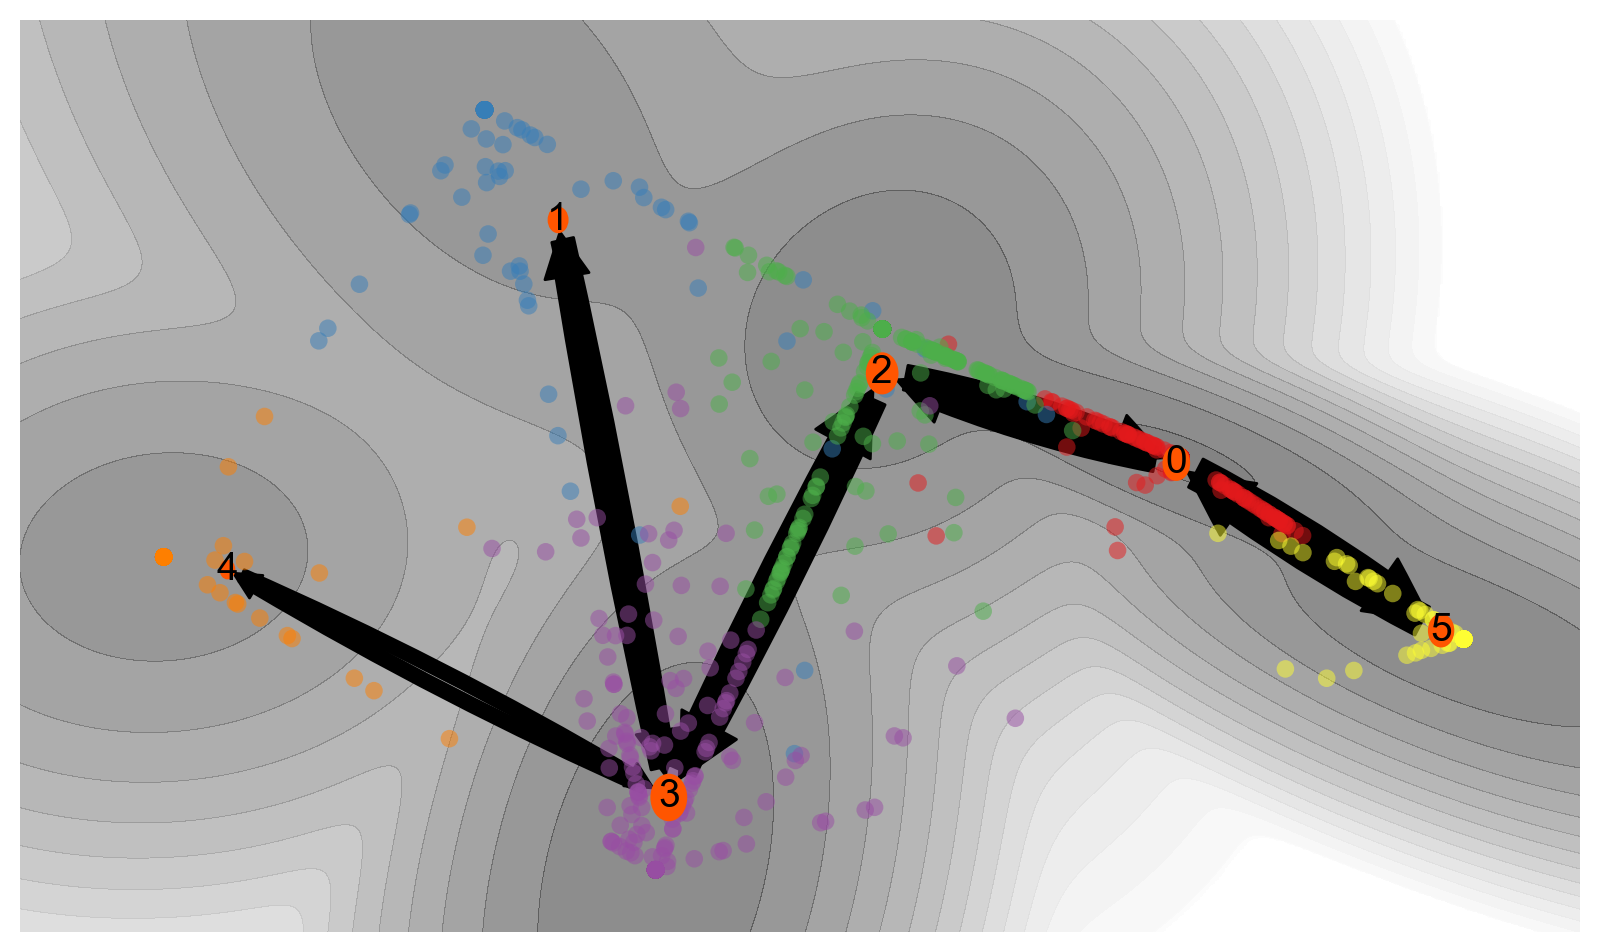

In [50]:
fig = plt.figure(figsize = (10, 6))
pm.infer_lineage(adata_mu, method = "MPFT", size_point = 40, alpha_point = 0.5, size_text = 15)
plt.savefig(plotdir+"entry_mpft.pdf")
plt.savefig(plotdir+"entry_mpft.png")

MPPT from 5 to 1

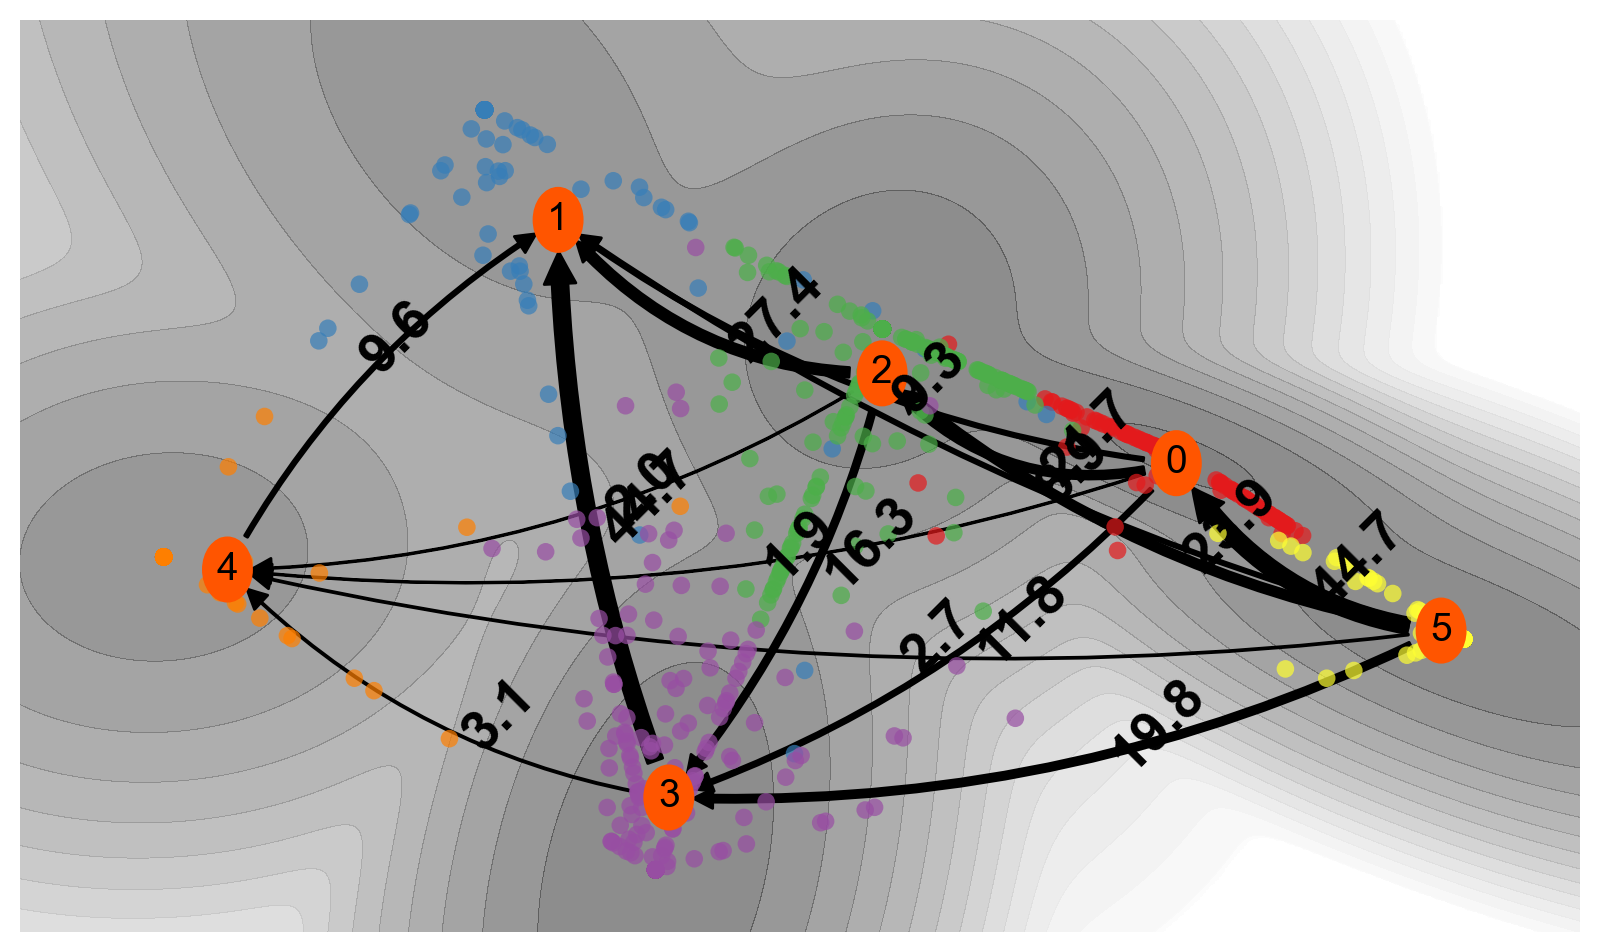

In [51]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 5,sf = 1, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"entry_mppt_5_to_1_100.pdf")
plt.savefig(plotdir+"entry_mppt_5_to_1_100.png")

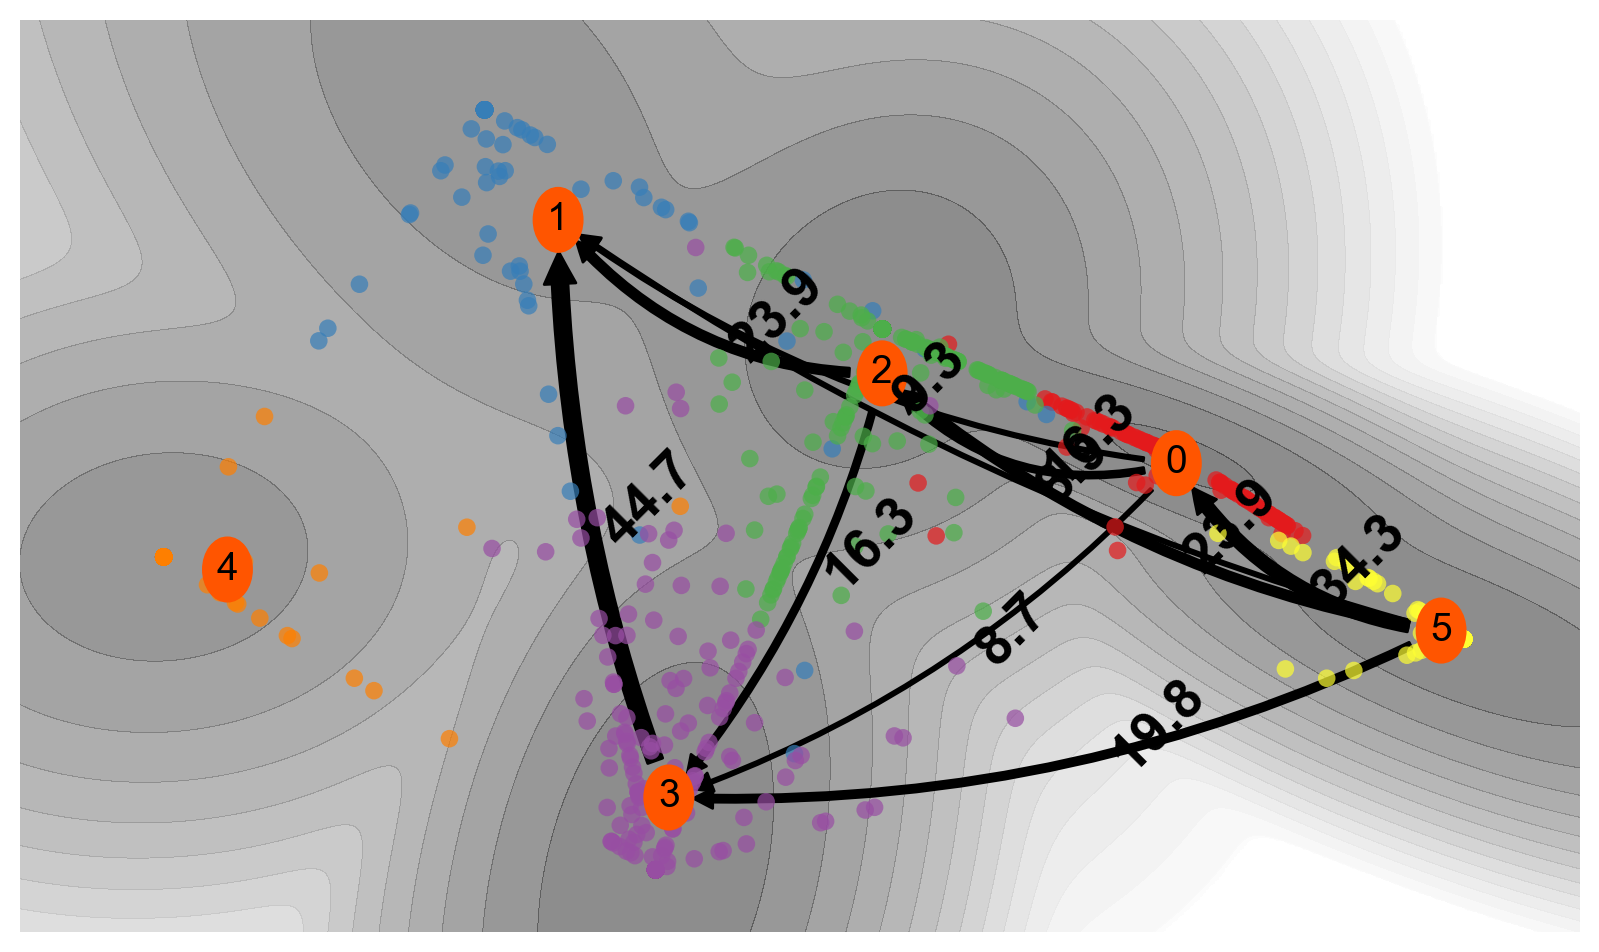

In [14]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 5,sf = 1, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"entry_mppt_5_to_1_90.pdf")
plt.savefig(plotdir+"entry_mppt_5_to_1_90.png")

MPPT from 5 to 4

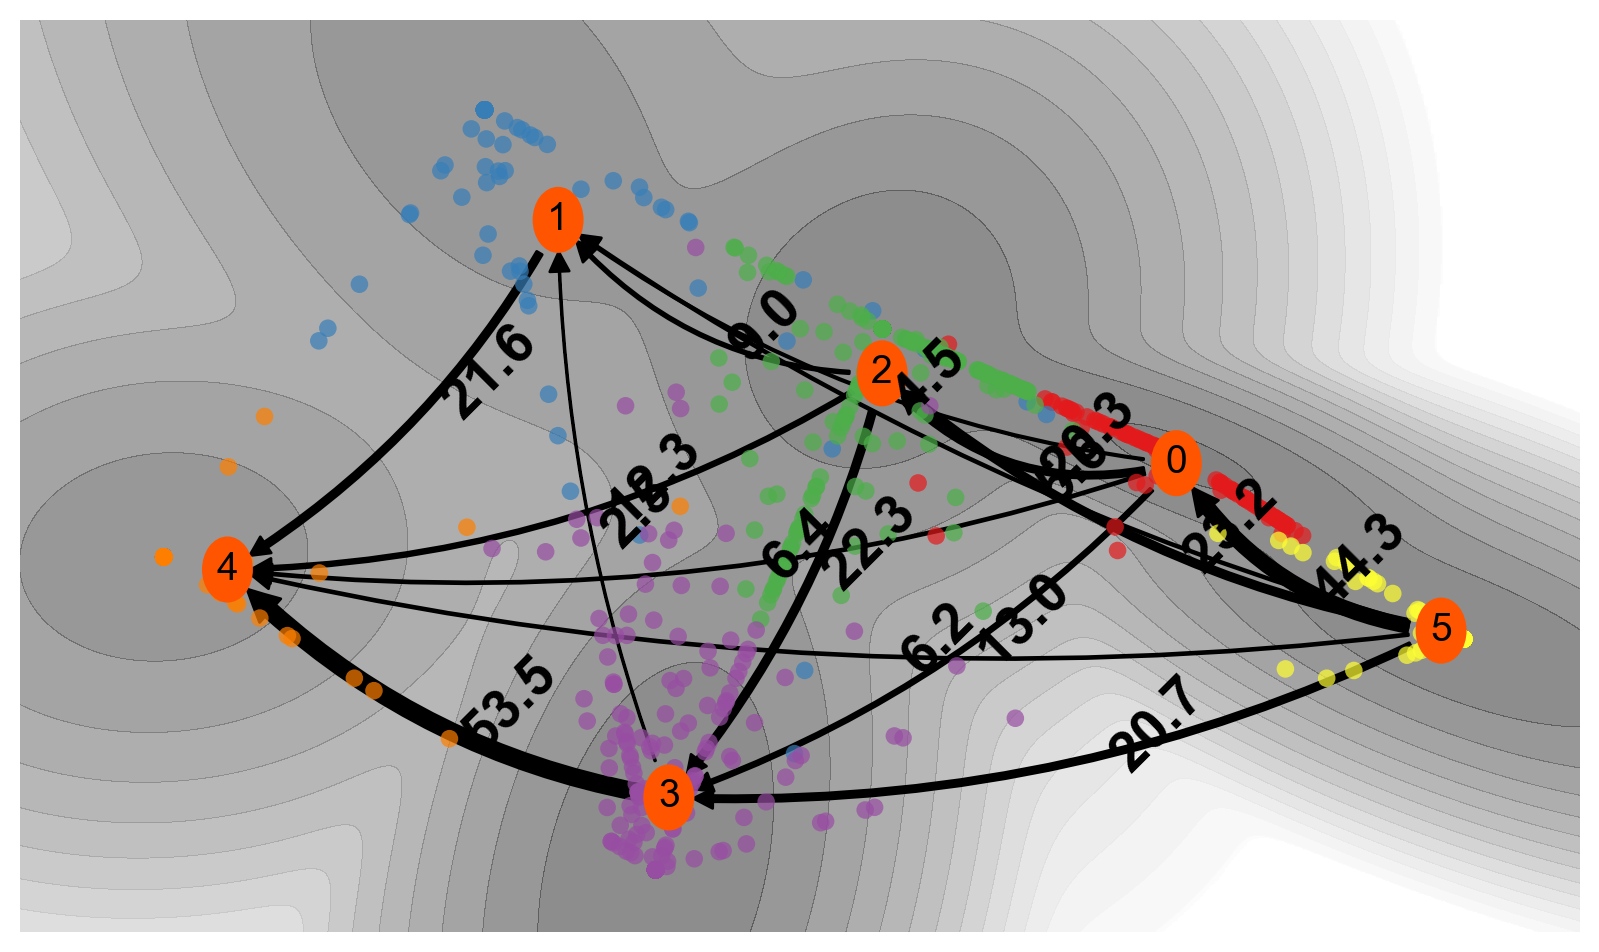

In [53]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 5,sf = 4, flux_fraction = 1, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"entry_mppt_5_to_4_100.pdf")
plt.savefig(plotdir+"entry_mppt_5_to_4_100.png")

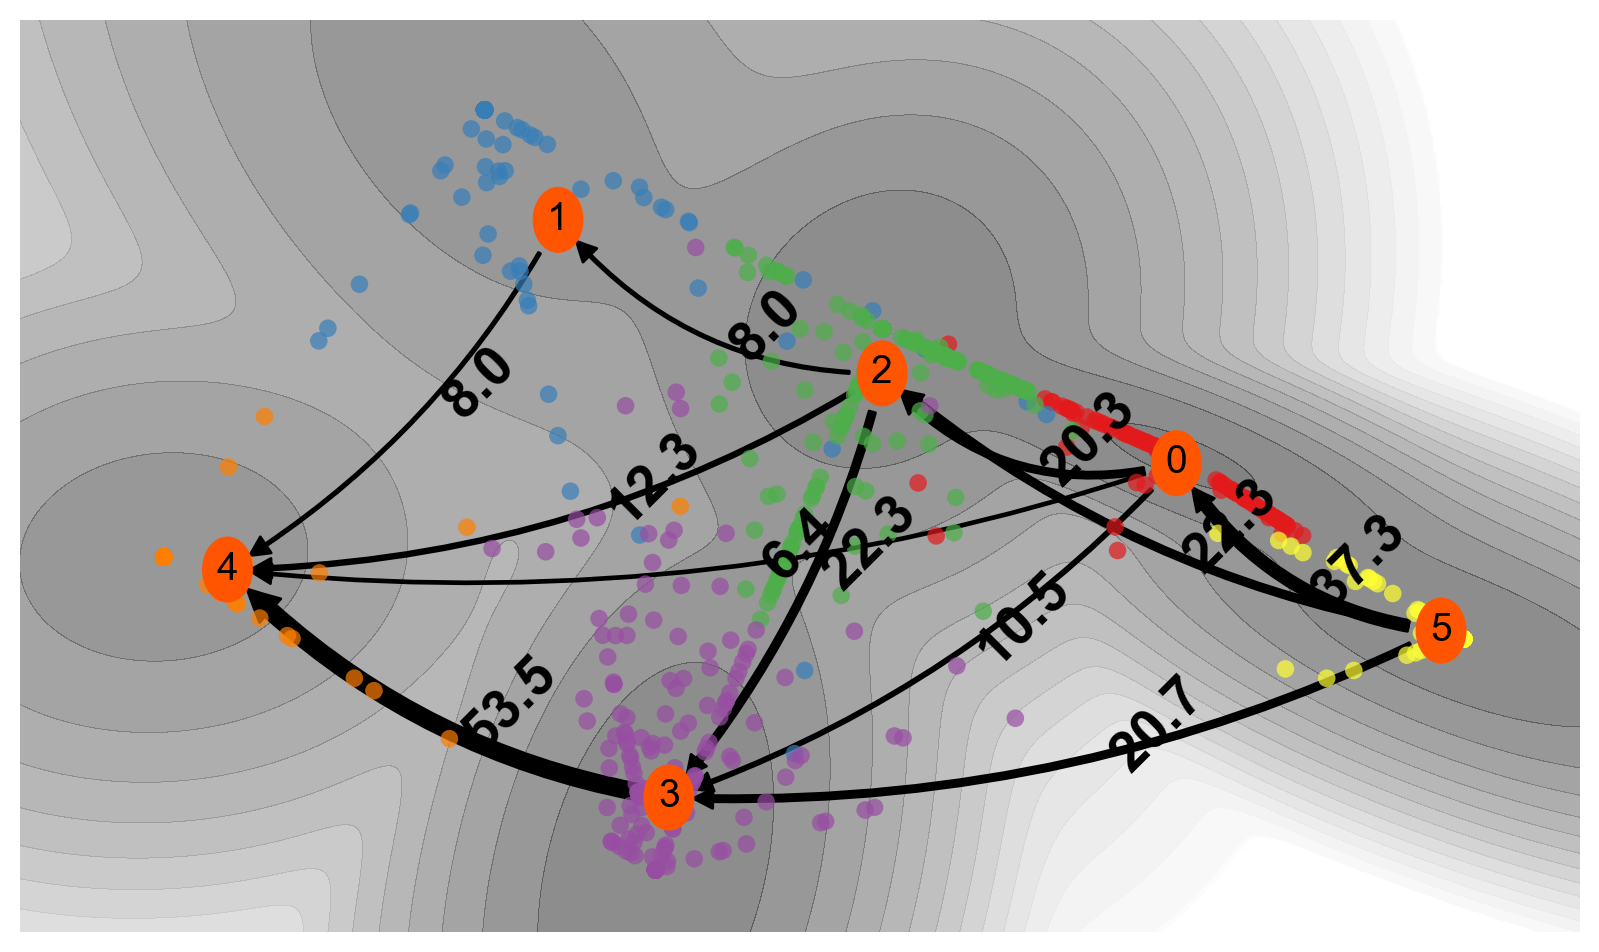

In [18]:
fig = plt.figure(figsize = (10,6))
pm.infer_lineage(adata_mu,si = 5,sf = 4, flux_fraction = 0.9, method = "MPPT", size_state = 0.2, size_point = 40, size_text = 20, alpha_point = 0.7)
plt.savefig(plotdir+"entry_mppt_5_to_4_90.pdf")
plt.savefig(plotdir+"entry_mppt_5_to_4_90.png")

In [55]:
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')

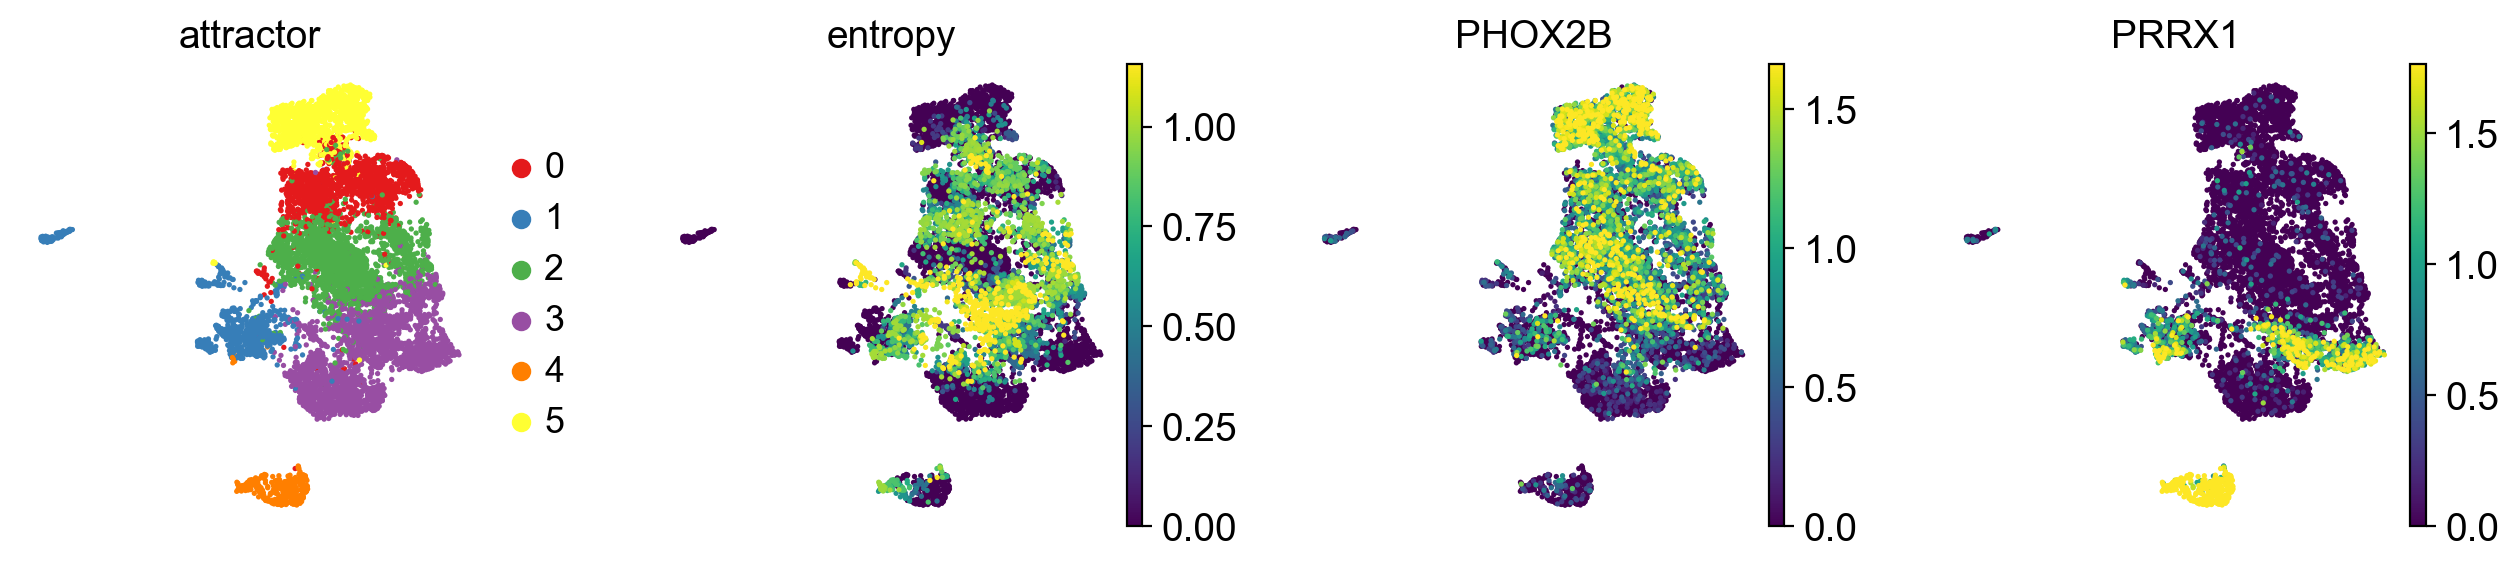

In [56]:
color_palette = sns.color_palette('Set1', 6)
sc.pl.umap(adata_mu, color = ['attractor', 'entropy', 'PHOX2B', 'PRRX1'], vmax = 'p95', palette = color_palette, show = False)
plt.savefig(plotdir+"entry_umap_attractor_entropy.pdf")
plt.savefig(plotdir+"entry_umap_attractor_entropy.png")

In [57]:
for keys in list(adata_mu.uns['da_out'].keys()):
    if type(adata_mu.uns['da_out'][keys]).__name__ == 'double':
        adata_mu.uns['da_out'][keys] = np.asarray(adata_mu.uns['da_out'][keys])    

for keys in list(adata_mu.uns['land'].keys()):
    if type(adata_mu.uns['land'][keys]).__name__ == 'double':
        adata_mu.uns['land'][keys] = np.asarray(adata_mu.uns['land'][keys])    

del adata_mu.uns['land']['model']

adata_mu.write(datadir+'entry_mutrans.h5ad')

In [58]:
del adata_mu.uns['da_out']
del adata_mu.uns['land']

In [59]:
adata_mu.write_h5ad(
    datadir+"entry_mutrans_mod.h5ad",
    compression = hdf5plugin.FILTERS["zstd"]
)

#### Violin plots

In [3]:
plotdir = "../plots/entry/"

In [4]:
adata_mu = sc.read(datadir+'entry_mutrans.h5ad')
adata_mu.obs['attractor'] = adata_mu.obs.attractor.astype('category')
color_palette = sns.color_palette('Set1', 6)

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [5]:
conditions = [
    adata_mu.obs['attractor'] == 0,
    adata_mu.obs['attractor'] == 1,
    adata_mu.obs['attractor'] == 2,
    adata_mu.obs['attractor'] == 3,
    adata_mu.obs['attractor'] == 4,
    adata_mu.obs['attractor'] == 5
]

outputs = [
    'III', 'V', 'II', 'I', 'VI', 'IV'
]

In [6]:
adata_mu.obs['energy_rank'] = np.select(conditions, outputs)

In [8]:
energy_pal = {
    'I' : color_palette[3],
    'II' : color_palette[2],
    'III' : color_palette[0],
    'IV' : color_palette[5],
    'V' : color_palette[1],
    'VI' : color_palette[4]
}

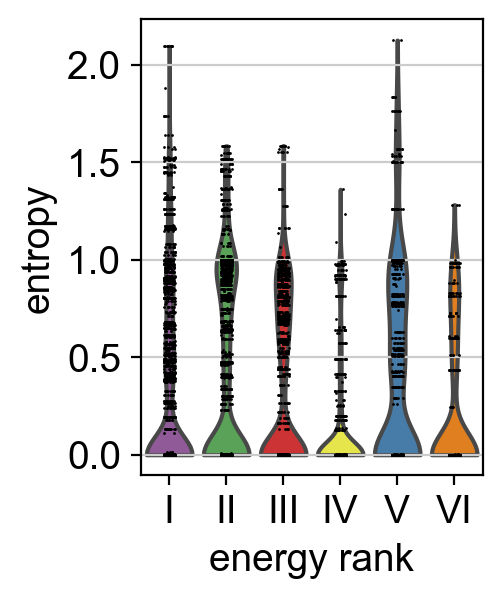

In [9]:
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(3, 3), facecolor='white')
sc.pl.violin(adata_mu, keys = 'entropy', groupby='energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"entry_violin_attractor_entropy_ranked.pdf")
plt.savefig(plotdir+"entry_violin_attractor_entropy_ranked.png")

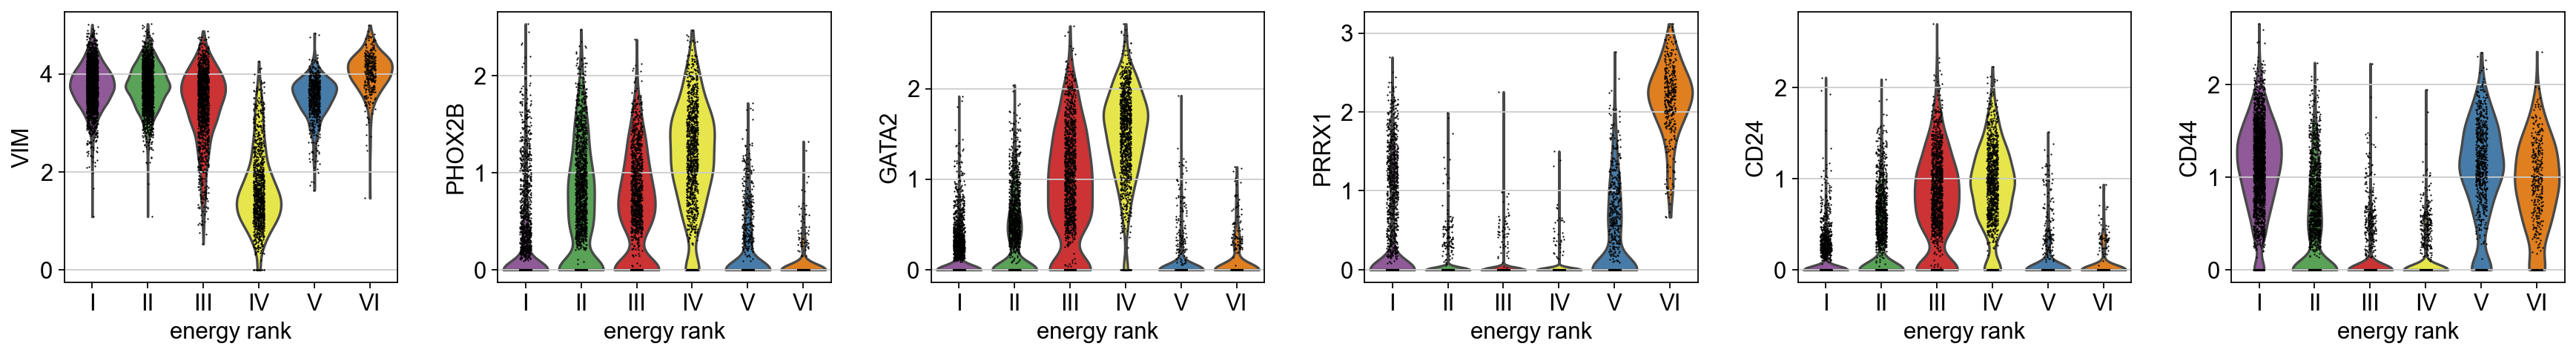

In [10]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = ['VIM','PHOX2B','GATA2','PRRX1','CD24','CD44'], groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"entry_violin_markers_ranked.pdf")
plt.savefig(plotdir+"entry_violin_markers_ranked.png")

In [11]:
adata_mu.write_h5ad(
    datadir+"entry_mutrans_ranked.h5ad",
    compression=hdf5plugin.FILTERS["zstd"]
)

#### Hybrid signature

In [13]:
plotdir = "../plots/entry/"
adata_mu = sc.read(datadir+'entry_mutrans_ranked.h5ad')

c:\Users\echen\Anaconda3\envs\mutrans\lib\site-packages\anndata\__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [7]:
hyb_sig = pd.read_csv(datadir+"method2_dge.csv")

In [9]:
hyb_list = hyb_sig['gene'].tolist()

In [14]:
sc.tl.score_genes(adata_mu, gene_list=hyb_list, ctrl_size=len(hyb_list), score_name="HYB.Sig")

In [17]:
color_palette = sns.color_palette('Set1', 6)
energy_pal = {
    'I' : color_palette[3],
    'II' : color_palette[2],
    'III' : color_palette[0],
    'IV' : color_palette[5],
    'V' : color_palette[1],
    'VI' : color_palette[4]
}

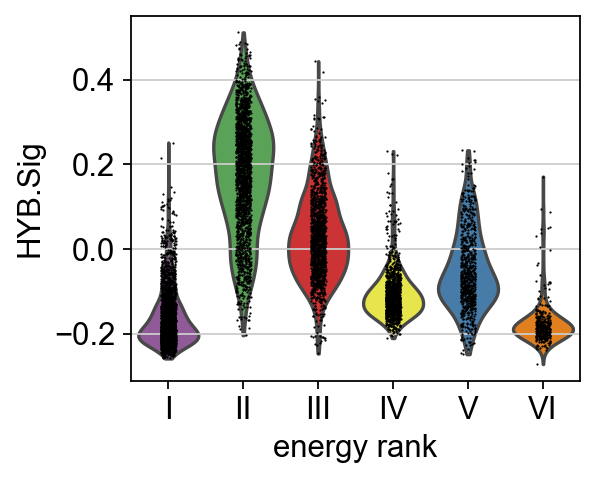

In [22]:
sc.settings.set_figure_params(frameon=False,figsize=(4, 3))
sc.pl.violin(adata_mu, keys = 'HYB.Sig', groupby = 'energy_rank', show=False, palette = energy_pal)
plt.savefig(plotdir+"entry_violin_hyb_ranked.pdf")
plt.savefig(plotdir+"entry_violin_hyb_ranked.png")